In [30]:
import gymnasium as gym
import numpy as np
# these are new packages in this file
# import panda_gym
# import stable_baselines3
# from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
# from stable_baselines3.common.env_util import make_vec_env
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

In [31]:
env_id = 'CartPole-v1'
env = gym.make(env_id)
state_space = env.observation_space
action_space = env.action_space.shape
print(f'state space: {state_space}')
print(f'action space: {action_space}')

state space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
action space: ()


In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# we don't use the Categorical since the actions are continuous
# we should use the Normal to model the continous distribution
from torch.distributions import Categorical

In [37]:
# we conbine the actornetwork and criticnetwork into a whole network
class ActorCritic(nn.Module):
    """This network includes a net to output action and a net to output value"""
    def __init__(
        self,
        state_space,
        action_space,
        lr,
        device,
        fc1_unit = 64,
        fc2_unit = 64
    ):
        super(ActorCritic,self).__init__()
        self.state_space = state_space
        self.action_space = action_space
        self.lr = lr
        self.device = device
        
        # nn.Sequential is really helpful
        # Actor
        self.actor = nn.Sequential(
            nn.Linear(state_space,fc1_unit),
            # in the sequential we should use the nn.ReLU() instead of torch.nn.functional.relu()
            # cause nn.ReLU is a module while functional.relu is a independent function
            nn.ReLU(),
            nn.Linear(fc1_unit,fc2_unit),
            nn.ReLU(),
            nn.Linear(fc2_unit,action_space)
        )
        
        # Critic
        self.critic = nn.Sequential(
            nn.Linear(state_space,fc1_unit),
            nn.ReLU(),
            nn.Linear(fc1_unit,fc2_unit),
            nn.ReLU(),
            nn.Linear(fc2_unit,1) # output the value
        )
        
        self.optimizer = optim.Adam(self.parameters(),lr = lr)
        self.to(self.device)
        
    def forward(self,state):
        
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        value = self.critic(state)
        
        # output the mean and std of action distribution
        x = self.actor(state)
        # why log_std?
        # because the log_std is (-infinite, +infinite)
        actions = F.softmax(x,dim=1)
        return value,actions
    

In [44]:
class Agent():
    def __init__(
        self,
        env: gym.envs,
        state_space: int,
        action_space: int,
        lr: float,
        device: torch.device,
        gamma: float, # discounted rewards
        n_training_episodes: int,
        max_t: int
    ):
        # init the variables
        self.env = env
        self.state_space = state_space
        self.action_space = action_space
        self.lr = lr
        self.device = device
        self.gamma = gamma
        self.n_training_episodes = n_training_episodes
        self.max_t = max_t
        
        self.actor_critic = ActorCritic(state_space,action_space,
                                        lr,device)
        
    def act(self,state):
        # choose an action given a state
        # if type(state) != 'torch.Tensor':
        #     state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        # the operation of sampling action is different with previous codes
        # we need use the Normal() to model the distribution using mean and log_std
        # then, sample the action
        value,probs = self.actor_critic(state)
        m = Categorical(probs.cpu())
        action = m.sample()
        # convert log_std to std
        
        return action.item(),m.log_prob(action)
    
    def step(self,action):
        # the agent take the action and obtain the next observation and immedient reward
        next_obs,reward,terminated,truncated,info = self.env.step(action)
        done = terminated or truncated
        return next_obs, reward, done
    
    def update(self,advantage,log_prob):
        """this is different with previous codes because we need to update two networks at each time_step"""
        # Note that Variable 'advantages' must be tensor
        policy_loss = -torch.mean(advantage * log_prob)
        value_loss = advantage
        
        total_loss = policy_loss + value_loss
        
        self.actor_critic.optimizer.zero_grad()
        total_loss.backward()
        self.actor_critic.optimizer.step()
        
    def train(self):
        """the agent will play many episodes and update it's parameters"""
        scores_deque = deque(maxlen=100)
        scores = []
        avg_scores = []
        
        for episode in range(self.n_training_episodes):
            # init some lists to store the infos
            rewards = []
            # in this method, we don't need to init saved_log_probs and rewards
            # since we update the network at each timestep
            # only need the immedient reward and predition of value
            
            
            state,info = self.env.reset()
            
            # loop max_t
            for t in range(self.max_t):
                # sample an action
                action,log_prob = self.act(state)
                # stepforward
                next_obs,reward,done = self.step(action)
                rewards.append(reward)
                # compute the advantage function
                # A = r + gamma * V(next) - V(now)
                value,_ = self.actor_critic(state)
                value_,_ = self.actor_critic(next_obs)
                advantage = torch.tensor(reward).float() + self.gamma * value_ - value
                self.update(advantage,log_prob)
                
                if done:
                    break
                
                state = next_obs
            
            scores_deque.append(sum(rewards))
            scores.append(sum(rewards))
            avg_scores.append(np.mean(scores_deque))
            
            if episode % 100 == 0:
                print(f'episode: {episode} | average score: {np.mean(scores_deque)}')
                
        fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
        fig.suptitle('Training Progress')

        ax1.plot(scores, label='Episode Scores', color='b')
        ax1.set_xlabel('Episode')
        ax1.set_ylabel('scores', color='b')
        ax1.tick_params(axis='y', labelcolor='b')

        ax2.plot(avg_scores, label='Episode Average Score', color='r')
        ax2.set_xlabel('Episode')
        ax2.set_ylabel('Average Score', color='r')
        ax2.tick_params(axis='y', labelcolor='r')
        
        

In [47]:
# Hyperparameters
state_space = env.observation_space.shape[0]
action_space = env.action_space.n
lr = 1e-2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gamma = 1.0
n_training_episodes = 2000
max_t = 1000

CartPoleAgent = Agent(
    env,
    state_space,
    action_space,
    lr,
    device,
    gamma,
    n_training_episodes,
    max_t
)

episode: 0 | average score: 15.0
episode: 100 | average score: 45.78
episode: 200 | average score: 52.2
episode: 300 | average score: 37.55
episode: 400 | average score: 47.76
episode: 500 | average score: 55.16
episode: 600 | average score: 94.76
episode: 700 | average score: 86.31
episode: 800 | average score: 85.0
episode: 900 | average score: 107.83
episode: 1000 | average score: 122.18
episode: 1100 | average score: 206.19
episode: 1200 | average score: 226.25
episode: 1300 | average score: 152.41
episode: 1400 | average score: 9.48
episode: 1500 | average score: 9.49
episode: 1600 | average score: 9.31
episode: 1700 | average score: 9.38
episode: 1800 | average score: 9.22
episode: 1900 | average score: 9.39


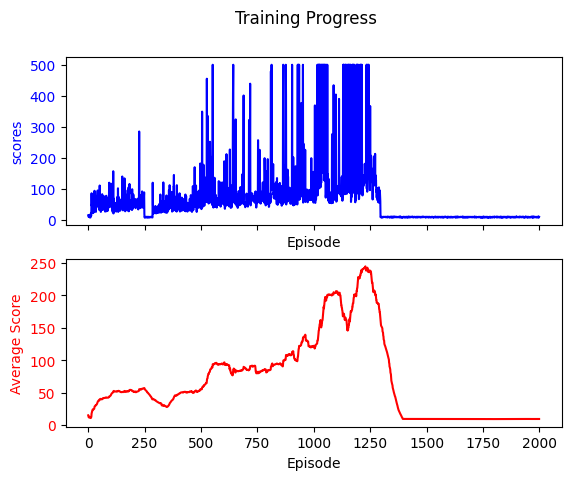

In [48]:
CartPoleAgent.train()